
INSTALLED VERSIONS
------------------
commit           : 8dab54d6573f7186ff0c3b6364d5e4dd635ff3e7
python           : 3.11.0.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 21.6.0
Version          : Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:35 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T8101
machine          : arm64
processor        : arm
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.UTF-8

pandas           : 1.5.2
numpy            : 1.23.5
pytz             : 2022.6
dateutil         : 2.8.2
setuptools       : 65.5.0
pip              : 22.3.1
Cython           : 0.29.32
pytest           : 7.2.0
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.9.1
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.6.0
pandas_datareader: 0.10.0
bs4              : 4

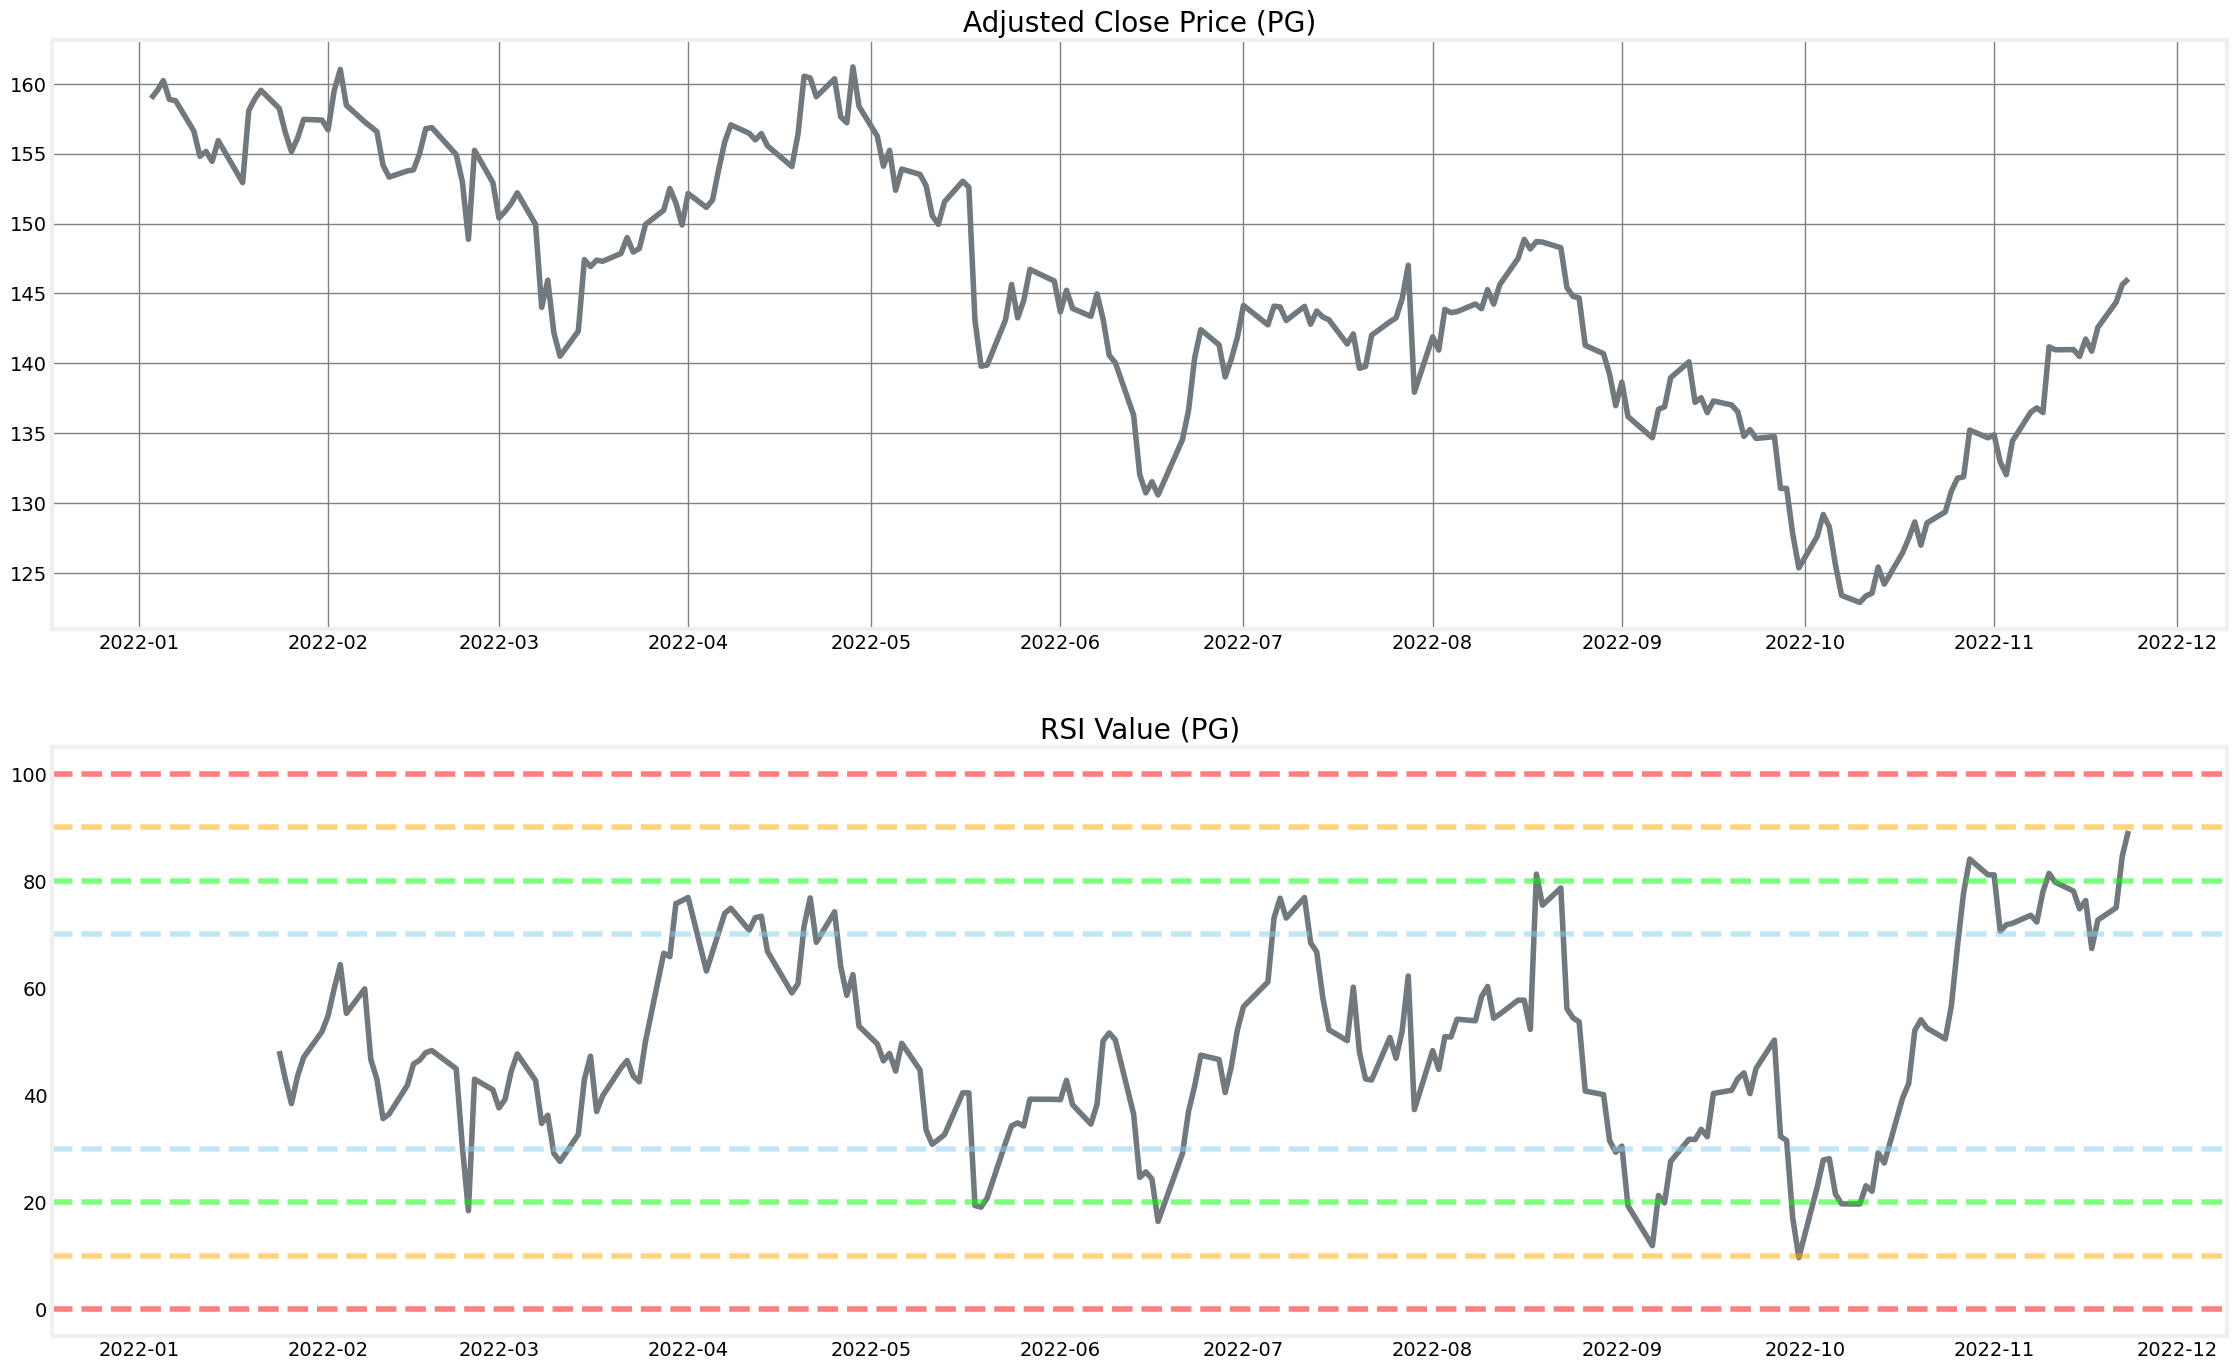

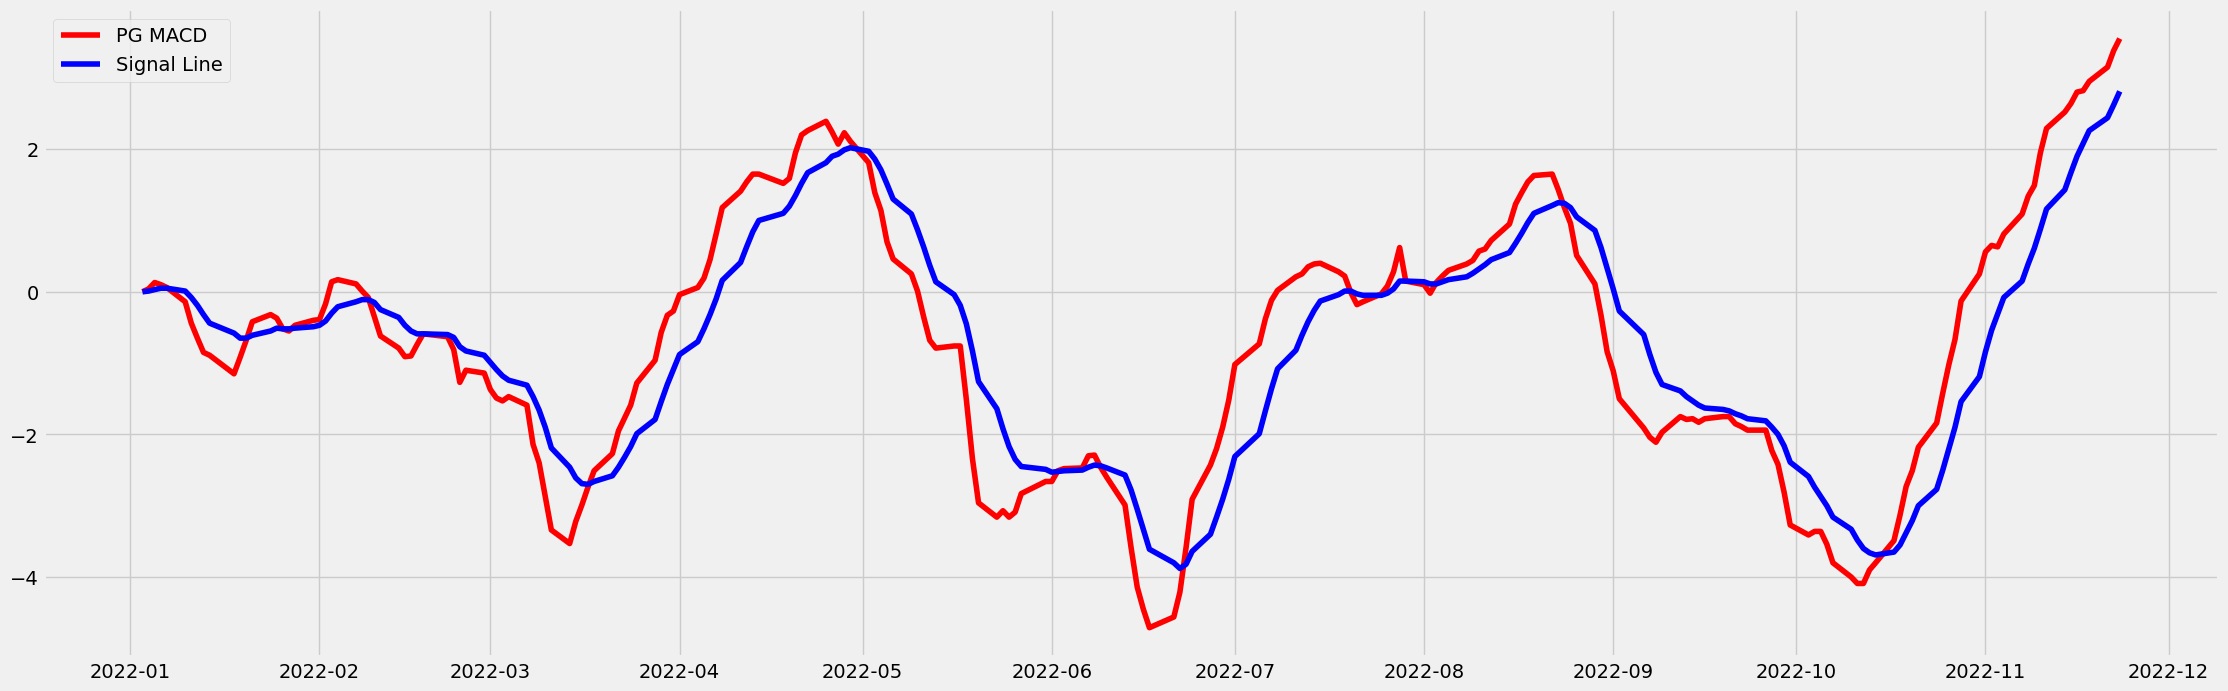

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pmdarima as pm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


pd.show_versions()
pd.set_option('display.max_rows', 50)

rsiPeriod = 14
maPeriods = [5, 9, 20, 50, 200]

yf.pdr_override()

startyear = int(input("Enter starting year: "))
startmonth = int(input("Enter starting month: "))
startday = int(input("Enter starting day: "))

start = dt.datetime(startyear, startmonth, startday)
now = dt.datetime.now()


class Error(Exception):
    pass

class InvalidMarket(Error):
    pass

while True:
    try:
        market1 = input("Enter a market: ")
        market1 = market1.upper()
        if market1 == "S&P" or market1 == "NASDAQ" or market1 == "SENSEX" or market1 == "HANG SENG" or market1 == "NIKKEI" or market1 == "LSE":
            stock1 = input("Enter a stock ticker symbol: ")
            stock1 = stock1.upper()
        else:
            raise InvalidMarket
        break
    except InvalidMarket:
        print("Market not registered in database. Please enter a registered market.")

if market1 == "S&P":
    df1 = pd.read_csv('S&P.csv')

if market1 == "NASDAQ":
    df1 = pd.read_csv("NASDAQ.csv")

if market1 == "LSE":
    df1 = pd.read_csv("LSE.csv")

if market1 == "SENSEX":
    df1 = pd.read_csv("SENSEX.csv")

if market1 == "NIKKEI":
    df1 = pd.read_csv("NIKKEI.csv")

if market1 == "HANG SENG":
    df1 = pd.read_csv("HANGSENG.csv")



for x in df1['Symbol']:
    if stock1 == x.upper():
        df_stock1 = pdr.get_data_yahoo(stock1, start, now)

        ## for moving averages

        for x in maPeriods:
            ma = x
            df_stock1['MA_' + str(ma)] = round(df_stock1.iloc[:, 4].rolling(window=ma).mean(), 2)


        ## for Moving Average Convergence Divergence (MACD) and Signal Line

        ## short term EMA

        ShortEMA1 = round(df_stock1.iloc[:, 4].ewm(span=12, adjust=False).mean(), 2)

        ## long term EMA

        LongEMA1 = round(df_stock1.iloc[:, 4].ewm(span=26, adjust=False).mean(), 2)

        ## MACD line

        MACD1 = ShortEMA1 - LongEMA1

        ## Signal line

        signal1 = round(MACD1.ewm(span=9, adjust=False).mean(), 2)

        df_stock1['MACD'] = MACD1
        df_stock1['Signal Line'] = signal1

        ## for RSI

        delta1 = df_stock1['Adj Close'].diff(1)
        delta1.dropna(inplace=True)  ## to drop rows which contain missing values

        positive1 = delta1.copy()
        negative1 = delta1.copy()


        positive1[positive1 < 0] = 0
        negative1[negative1 > 0] = 0


        avgGain1 = positive1.rolling(window=rsiPeriod).mean()
        avgLoss1 = abs(
            negative1.rolling(window=rsiPeriod).mean())  ## absolute value because we do not want a negative number
        relative_strength1 = avgGain1 / avgLoss1
        RSI1 = 100.0 - (100.0 / (1.0 + relative_strength1))


        df_stock1['RSI_14'] = RSI1


        print(df_stock1)


        combined = pd.DataFrame()  ## new column with Adj Close and RSI combined
        combined['Adj Close'] = df_stock1['Adj Close']
        combined['RSI'] = RSI1

        plt.figure(figsize=(25, 16))

        ## plotting Adjusted Close

        ax1 = plt.subplot(211)  ## number of rows is 2, number of column is 1, and plot number is 1
        ax1.plot(combined.index, combined['Adj Close'],
                 color='#71797E')  ## looks through every element in the Adj Close column
        ax1.set_title("Adjusted Close Price (" + stock1 + ")", color='black')

        ax1.grid(True, color='#808080')  ## for displaying grid lines
        ax1.set_axisbelow(True)
        ax1.set_facecolor('white')
        ax1.figure.set_facecolor('white')
        ax1.tick_params(axis='x', colors='black')
        ax1.tick_params(axis='y', colors='black')

        ## plotting RSI

        ax2 = plt.subplot(212, sharex=ax1)
        ax2.plot(combined.index, combined['RSI'], color='#71797E')
        ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')
        ax2.axhline(10, linestyle='--', alpha=0.5, color='#ffaa00')
        ax2.axhline(20, linestyle='--', alpha=0.5, color='#00ff00')
        ax2.axhline(30, linestyle='--', alpha=0.5, color='#89CFF0')
        ax2.axhline(70, linestyle='--', alpha=0.5, color='#89CFF0')
        ax2.axhline(80, linestyle='--', alpha=0.5, color='#00ff00')
        ax2.axhline(90, linestyle='--', alpha=0.5, color='#ffaa00')
        ax2.axhline(100, linestyle='--', alpha=0.5, color='#ff0000')

        ax2.set_title("RSI Value (" + stock1 + ")", color='black')
        ax2.grid(False)  ## for displaying grid lines
        ax2.set_axisbelow(True)
        ax2.set_facecolor('white')
        ax2.tick_params(axis='x', colors='black')
        ax2.tick_params(axis='y', colors='black')

        plt.show()

        ## plotting MACD and Signal line chart

        plt.figure(figsize=(25, 8))
        plt.plot(df_stock1.index, MACD1, label=stock1 + " MACD", color='red')
        plt.plot(df_stock1.index, signal1, label="Signal Line", color='blue')
        plt.legend(loc='upper left')
        plt.grid(True)

        plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



INSTALLED VERSIONS
------------------
commit           : 8dab54d6573f7186ff0c3b6364d5e4dd635ff3e7
python           : 3.11.0.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 21.6.0
Version          : Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:35 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T8101
machine          : arm64
processor        : arm
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.UTF-8

pandas           : 1.5.2
numpy            : 1.23.5
pytz             : 2022.6
dateutil         : 2.8.2
setuptools       : 65.5.0
pip              : 22.3.1
Cython           : 0.29.32
pytest           : 7.2.0
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.9.1
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.6.0
pandas_datareader: 0.10.0
bs4              : 4

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(5, 1, 10)   Log Likelihood                -480.274
Date:                Wed, 23 Nov 2022   AIC                            992.549
Time:                        19:37:36   BIC                           1047.206
Sample:                             0   HQIC                          1014.609
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3491      1.765     -0.198      0.843      -3.809       3.111
ar.L2          0.1171      0.736      0.159      0.874      -1.326       1.560
ar.L3         -0.2762      0.611     -0.452      0.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36887D+00    |proj g|=  4.51784D-01

At iterate    5    f=  2.11762D+00    |proj g|=  7.93626D-02

At iterate   10    f=  2.08984D+00    |proj g|=  1.22450D-02

At iterate   15    f=  2.08196D+00    |proj g|=  3.74947D-02

At iterate   20    f=  2.07931D+00    |proj g|=  2.57187D-02

At iterate   25    f=  2.07867D+00    |proj g|=  1.00916D-02

At iterate   30    f=  2.07838D+00    |proj g|=  7.44071D-03

At iterate   35    f=  2.07765D+00    |proj g|=  2.13987D-02

At iterate   40    f=  2.07673D+00    |proj g|=  2.15614D-02

At iterate   45    f=  2.07610D+00    |proj g|=  2.08451D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.07560D+00    |proj g|=  3.87957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     58      1     0     0   3.880D-02   2.076D+00
  F =   2.0755950020782876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  226
Model:             SARIMAX(5, 1, 10)x(5, 1, 10, 12)   Log Likelihood                -469.084
Date:                              Wed, 23 Nov 2022   AIC                         

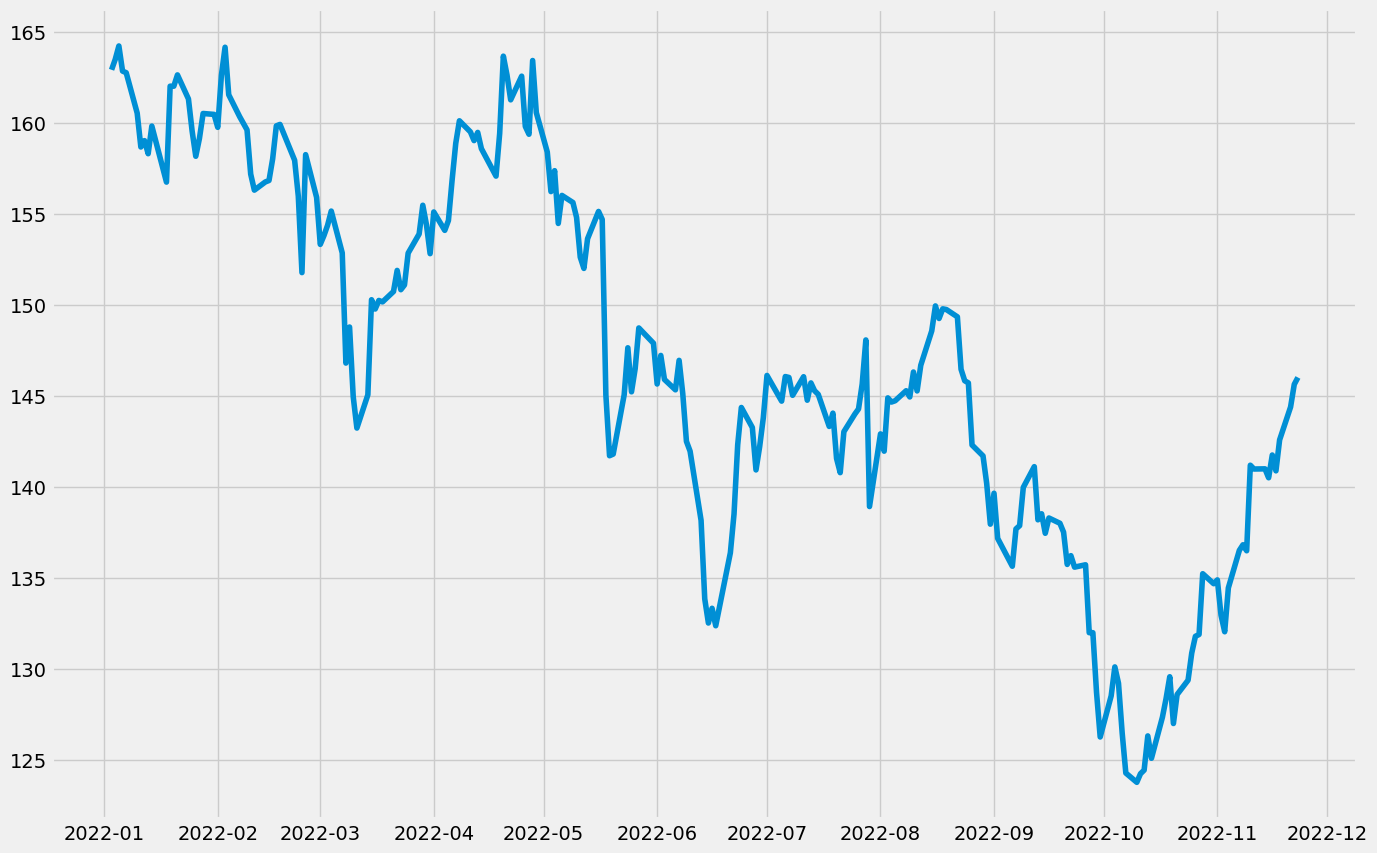

<Figure size 640x480 with 0 Axes>

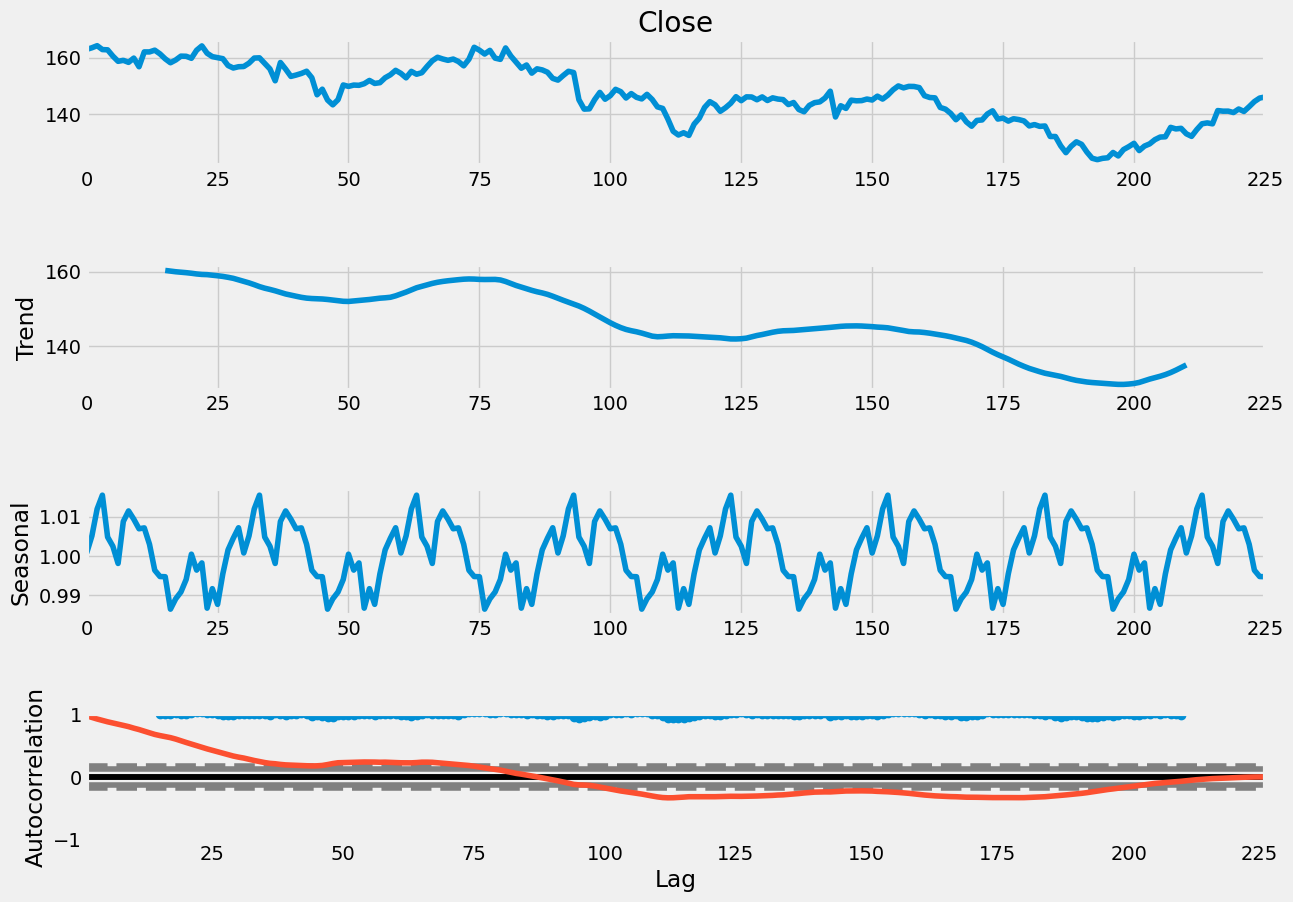

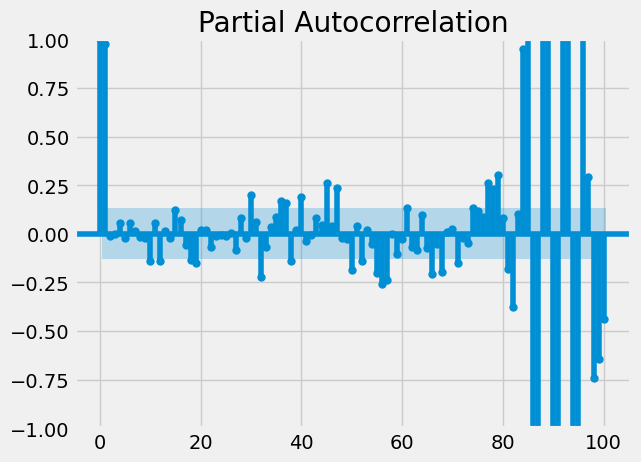

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pmdarima as pm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings


pd.show_versions()
pd.set_option('display.max_rows', 50)


yf.pdr_override()

startyear = int(input("Enter starting year: "))
startmonth = int(input("Enter starting month: "))
startday = int(input("Enter starting day: "))

start = dt.datetime(startyear, startmonth, startday)
now = dt.datetime.now()

df2=yf.download("PG", start=start, end=now, progress=False) #enter ticker here
df2["Date"]=df2.index
df2=df2[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df2.reset_index(drop=True, inplace=True)
        
                    
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(df2["Date"], df2["Close"])    
        
result = seasonal_decompose(df2["Close"], model = "multiplicative", period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

pd.plotting.autocorrelation_plot(df2["Close"]) 
plot_pacf(df2["Close"], lags = 100) #for partial autocorrelation
        
p, d, q = 5, 1, 10
model = sm.tsa.ARIMA(df2["Close"], order=(p,d,q)) 
fitted = model.fit()  
print(fitted.summary())
        
predictions = fitted.predict()
print(predictions)
    
model=sm.tsa.statespace.SARIMAX(df2['Close'],
                        order=(p, d, q),
                        seasonal_order=(p, d, q, 12))

model=model.fit()
print(model.summary())



                

226    145.759331
227    144.019869
228    143.849807
229    143.094365
230    143.812557
231    143.362981
232    141.479775
233    141.248976
234    140.662655
235    139.917856
236    141.141684
237    142.022537
238    142.745148
239    141.254981
240    141.737936
241    140.505410
242    141.826850
243    142.000841
244    141.738823
245    140.834945
246    141.226831
247    140.982177
248    141.684309
249    141.585068
250    141.398989
251    141.572040
252    140.673893
253    139.423094
254    139.994888
255    140.800203
256    140.005445
257    140.032472
258    139.664594
259    138.920993
260    139.673557
261    139.795197
262    140.289819
263    138.413196
264    139.082717
265    138.278832
266    139.472150
267    139.606511
268    139.055325
269    138.758820
270    137.672793
271    137.575264
272    138.505201
273    139.391361
274    140.493089
275    139.867389
276    139.655679
Name: predicted_mean, dtype: float64


<AxesSubplot: >

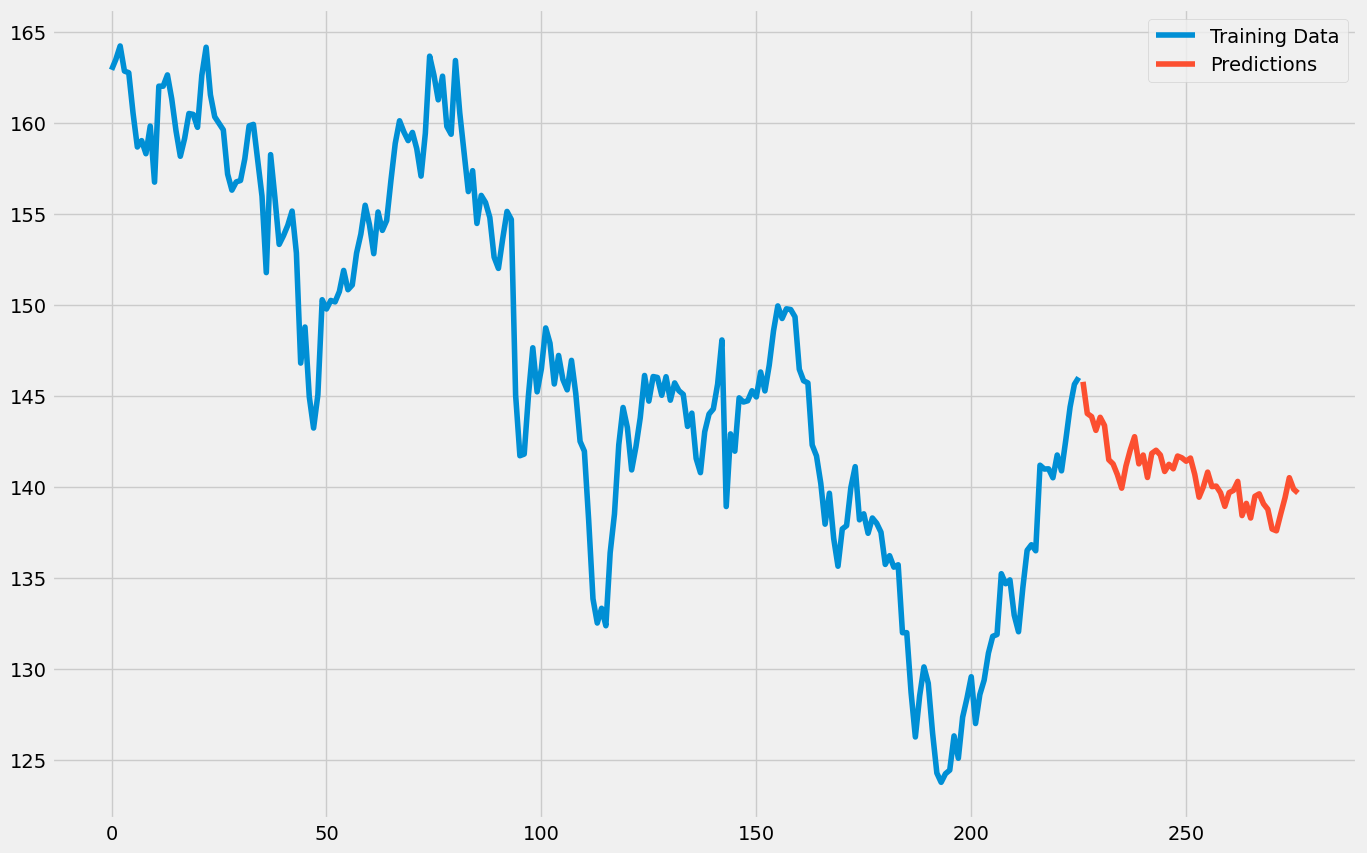

In [2]:
pd.set_option('display.max_rows', None)
predictions = model.predict(len(df2), len(df2)+50)
print(predictions)
        
df2["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")
        
